In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import tweepy
import matplotlib.pyplot as plt
import sys
import requests
import json
sys.path.append("../")
from settings import APIKEY, APISECRETKEY, ACCESSTOKEN, ACCESSTOKENSECRET

In [40]:
tweets = pd.read_csv("../data/raw/article_tweets.csv")
claims = pd.read_pickle("../data/external/combined_data.pkl")
keywords = pd.read_csv("../data/external/all_keywords.csv")
organizations = pd.read_csv("../data/external/all_organisations.csv")

## Testing out hoaxy api

In [43]:
domains = organizations.loc[organizations.name.str.contains("\.")].copy()

In [44]:
domains

,Unnamed: 0,@id,@type,location,name,sameAs,creativeWorksCount
5,6,/organizations/6,http://schema.org/Organization,NaN,midline-news.net,NaN,NaN
11,12,/organizations/12,http://schema.org/Organization,NaN,emeknes.com,NaN,NaN
13,14,/organizations/14,http://schema.org/Organization,NaN,elbayan-news.com,NaN,NaN
14,15,/organizations/15,http://schema.org/Organization,NaN,masr20.com,NaN,NaN
15,16,/organizations/16,http://schema.org/Organization,NaN,abudhabi-news.com,NaN,NaN
...,...,...,...,...,...,...,...
1255,1256,/organizations/1256,http://schema.org/Organization,/countries/4,sputniknews.com,NaN,NaN
1256,1257,/organizations/1257,http://schema.org/Organization,NaN,nv.ua,NaN,NaN
1257,1258,/organizations/1258,http://schema.org/Organization,NaN,webnovosti.info,NaN,NaN
1258,1259,/organizations/1259,http://schema.org/Organization,/countries/4,sputniknews.com,NaN,NaN


In [68]:
organizations.loc[organizations.name.str.contains("russia-insider.com")]

,Unnamed: 0,@id,@type,location,name,sameAs,creativeWorksCount
82,83,/organizations/83,http://schema.org/Organization,NaN,YouTube channel // russia-insider.com,NaN,NaN


In [61]:
def search_for_domain(domain):
    url = "https://api-hoaxy.p.rapidapi.com/articles"

    querystring = {"query":f"domain:{domain}","use_lucene_syntax":"true","sort_by":"relevant"}

    headers = {
        'x-rapidapi-host': "api-hoaxy.p.rapidapi.com",
        'x-rapidapi-key': "4ae43af1f2mshf4db477a8729603p1bc1c5jsn4b8f903673bb"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)

    data = json.loads(response.text)
    return data

In [2]:
def search_for_title(title):
    url = "https://api-hoaxy.p.rapidapi.com/articles"

    querystring = {"query":f"title:{title}","use_lucene_syntax":"true","sort_by":"relevant"}

    headers = {
        'x-rapidapi-host': "api-hoaxy.p.rapidapi.com",
        'x-rapidapi-key': "4ae43af1f2mshf4db477a8729603p1bc1c5jsn4b8f903673bb"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)

    data = json.loads(response.text)
    return data

In [10]:
def get_network(articles):
    url = "https://api-hoaxy.p.rapidapi.com/network"

    querystring = {"ids":f"{articles}","nodes_limit":"1000","edges_limit":"12500","include_user_mentions":"true"}

    headers = {
        'x-rapidapi-host': "api-hoaxy.p.rapidapi.com",
        'x-rapidapi-key': "4ae43af1f2mshf4db477a8729603p1bc1c5jsn4b8f903673bb"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)

    network = json.loads(response.text)
    return network

In [3]:
article_title = 'Russia announces retaliation over RT DE ban in Germany'
article = search_for_title(article_title)

In [51]:
articles = [article['articles'][1]['id']]

In [18]:
ids = [a['id'] for a in article['articles']]

In [52]:
network = get_network(articles)

In [53]:
edges = [(e['from_user_id'], e['to_user_id']) for e in network['edges']]
G = nx.DiGraph()
G.add_edges_from(edges)

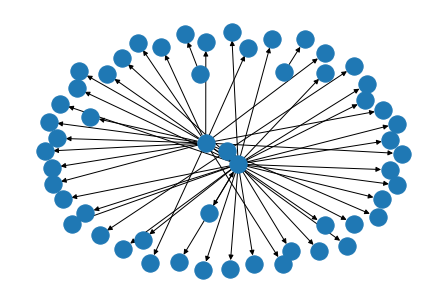

In [54]:
nx.draw(G)

## Trying to construct network myself

In [41]:
top_claim = tweets.claim.value_counts().keys()[0]
sample = tweets.loc[tweets.claim == top_claim]

In [77]:
sample.columns

Index(['claim', 'url', 'date', 'content', 'renderedContent', 'id',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags', 'username', 'displayname',
       'description', 'rawDescription', 'descriptionUrls', 'verified',
       'created', 'followersCount', 'friendsCount', 'statusesCount',
       'favouritesCount', 'listedCount', 'mediaCount', 'location', 'protected',
       'linkUrl', 'linkTcourl', 'profileImageUrl', 'profileBannerUrl', 'label',
       'user_id'],
      dtype='object')

In [85]:
sample.loc[sample.retweetCount > 5].iloc[-1].url

'https://twitter.com/RT_com/status/1206134035338203136'

In [80]:
sample.loc[sample.mentionedUsers.notnull()]

,claim,url,date,content,renderedContent,id,replyCount,retweetCount,likeCount,quoteCount,...,listedCount,mediaCount,location,protected,linkUrl,linkTcourl,profileImageUrl,profileBannerUrl,label,user_id
179,OPCW has deliberately falsified Douma report t...,https://twitter.com/GordBolton/status/12065380...,2019-12-16 11:34:29+00:00,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,1206538079542005760,0.0,0.0,0.0,0.0,...,73.0,44416.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/107872815...,https://pbs.twimg.com/profile_banners/22658856...,NaN,2265885618
203,OPCW has deliberately falsified Douma report t...,https://twitter.com/MuammarFidel/status/120629...,2019-12-15 19:46:15+00:00,@DerbyChrisW https://t.co/UDMFRu9jOT,@DerbyChrisW rt.com/news/475926-op…,1206299451377246208,0.0,0.0,0.0,0.0,...,0.0,10.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/119691606...,NaN,NaN,1196914831636541440
213,OPCW has deliberately falsified Douma report t...,https://twitter.com/JohnDelacour/status/120626...,2019-12-15 17:18:36+00:00,#OPCW_FRAUD @OPCW \n#Douma_Hoax #SARIN_HOAX #S...,#OPCW_FRAUD @OPCW \n#Douma_Hoax #SARIN_HOAX #S...,1206262293056704512,2.0,1.0,4.0,0.0,...,97.0,14206.0,"Кронштадт, Санкт-Петербург",False,NaN,NaN,https://pbs.twimg.com/profile_images/939908688...,https://pbs.twimg.com/profile_banners/24622682...,NaN,2462268236
228,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:23:48+00:00,@SulomeAnderson @bellingcat When the fingerpri...,@SulomeAnderson @bellingcat When the fingerpri...,1206233401453424640,0.0,0.0,2.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
229,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:10:57+00:00,"@SenSanders ""Bashar Assad's chemical attack......","@SenSanders ""Bashar Assad's chemical attack......",1206230169884737536,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
238,OPCW has deliberately falsified Douma report t...,https://twitter.com/JamazingPal/status/1206185...,2019-12-15 12:15:09+00:00,"Hey @AIPAC, tell us who gave US intel report a...","Hey @AIPAC, tell us who gave US intel report a...",1206185927682543616,0.0,0.0,0.0,0.0,...,0.0,12.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/117687703...,https://pbs.twimg.com/profile_banners/10670696...,NaN,1067069696636305408
246,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 10:24:49+00:00,@whitehelmets90 https://t.co/9wnYWjJonX,@whitehelmets90 rt.com/news/475926-op…,1206158160148471808,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
253,OPCW has deliberately falsified Douma report t...,https://twitter.com/RT_com/status/120613403533...,2019-12-15 08:48:57+00:00,The team on the ground in #Douma was apparentl...,The team on the ground in #Douma was apparentl...,1206134035338203136,4.0,11.0,17.0,0.0,...,20749.0,184204.0,NaN,False,http://RT.com,https://t.co/gtHSJ8TMVD,https://pbs.twimg.com/profile_images/101883390...,https://pbs.twimg.com/profile_banners/64643056...,UserLabel(description='Russia state-affiliated...,64643056


In [76]:
sample.loc[sample.inReplyToUser.notnull()]

,claim,url,date,content,renderedContent,id,replyCount,retweetCount,likeCount,quoteCount,...,listedCount,mediaCount,location,protected,linkUrl,linkTcourl,profileImageUrl,profileBannerUrl,label,user_id
168,OPCW has deliberately falsified Douma report t...,https://twitter.com/AndyWu007/status/120681370...,2019-12-17 05:49:43+00:00,Contoh gampang hoax soal papua yg gunain senja...,Contoh gampang hoax soal papua yg gunain senja...,1206813705456898048,0.0,1.0,1.0,0.0,...,0.0,353.0,Singapore,False,NaN,NaN,https://pbs.twimg.com/profile_images/811923725...,https://pbs.twimg.com/profile_banners/81192209...,NaN,811922097748312064
179,OPCW has deliberately falsified Douma report t...,https://twitter.com/GordBolton/status/12065380...,2019-12-16 11:34:29+00:00,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,1206538079542005760,0.0,0.0,0.0,0.0,...,73.0,44416.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/107872815...,https://pbs.twimg.com/profile_banners/22658856...,NaN,2265885618
203,OPCW has deliberately falsified Douma report t...,https://twitter.com/MuammarFidel/status/120629...,2019-12-15 19:46:15+00:00,@DerbyChrisW https://t.co/UDMFRu9jOT,@DerbyChrisW rt.com/news/475926-op…,1206299451377246208,0.0,0.0,0.0,0.0,...,0.0,10.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/119691606...,NaN,NaN,1196914831636541440
228,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:23:48+00:00,@SulomeAnderson @bellingcat When the fingerpri...,@SulomeAnderson @bellingcat When the fingerpri...,1206233401453424640,0.0,0.0,2.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
229,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:10:57+00:00,"@SenSanders ""Bashar Assad's chemical attack......","@SenSanders ""Bashar Assad's chemical attack......",1206230169884737536,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
246,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 10:24:49+00:00,@whitehelmets90 https://t.co/9wnYWjJonX,@whitehelmets90 rt.com/news/475926-op…,1206158160148471808,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432


In [57]:
claims.loc[claims.claim == top_claim].links.values[0]

['https://www.rt.com/news/475926-opcw-leaks-report-syria-chemical/',
 'https://eadaily.com/ru/news/2019/12/15/daily-mail-poyavilis-novye-svidetelstva-feyka-o-himatake-asada-v-dume']

In [58]:
top_claim

'OPCW has deliberately falsified Douma report to blame the Assad Government'

In [61]:
claims

,date,claim,links,organizations,keywords,countries
0,2020-01-02T00:00:00+00:00,Ukraine does not want to buy gas from Russia b...,[https://russian.rt.com/ussr/article/704353-ga...,[russian.rt.com],"[gas, Oligarchs, Trade]","[Russia, Ukraine]"
1,2020-01-01T00:00:00+00:00,There is no freedom of speech in Estonia,[https://sputnik-news.ee/estonian_news/2020010...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
2,2019-12-31T00:00:00+00:00,The regime in Estonia publicly persecutes its ...,[https://sputnik-news.ee/estonian_news/2019123...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
3,2019-12-29T00:00:00+00:00,Poland started World War II,[],[],[WWII],[Poland]
4,2019-12-28T00:00:00+00:00,There are no lies coming from Sputnik,[https://sputnik-news.ee/estonian_news/2019122...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
...,...,...,...,...,...,...
7223,2015-03-11T00:00:00+00:00,Massive rally against NATO membership took pla...,[http://webcache.googleusercontent.com/search?...,[slobodnimediji.com],"[NATO, Vladimir Putin]","[Russia, Czech Republic]"
7224,2015-02-11T00:00:00+00:00,The migration crisis is a US-led operation wit...,[],[],"[Conspiracy, Migration crisis]","[US, EU]"
7225,2015-02-11T00:00:00+00:00,The Ukrainian revolution was organized by the ...,[http://www.casopis-sifra.cz/nikolaj-starikov-...,[Nikolai Starikov],[Euromaidan],"[US, Ukraine]"
7226,2015-01-25T00:00:00+00:00,There is a state-supported national tradition ...,[http://www.biosferaklub.info/co-se-na-nas-hrn...,"[czechfreepress.cz, biosferaklub.info// czechf...","[Stealing children, Perversion]",[Norway]


## Graph Embedding

In [18]:
from karateclub.dataset import GraphSetReader
from karateclub import FeatherGraph

reader = GraphSetReader("reddit10k")

graphs = reader.get_graphs()
y = reader.get_target()

model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()
X.shape

In [48]:
from sklearn.metrics.pairwise import cosine_similarity 
similarity = cosine_similarity(X)

0.789149999430017

In [49]:
similarity[0].argmin()

49

### Graph most different from the first graph 

They are classified differently in the dataset which is promising

In [59]:
y[0]

0

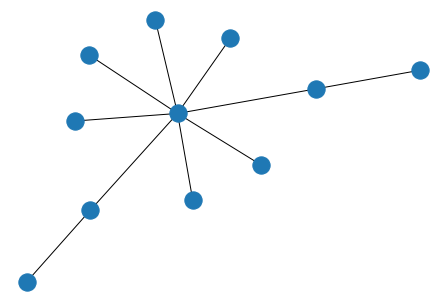

In [55]:
nx.draw(graphs[0])

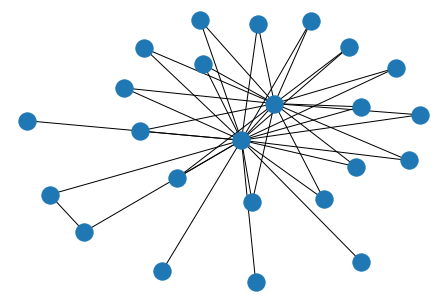

In [54]:
nx.draw(graphs[49])

In [58]:
y[49]

1